In [11]:
cd ..

/home/martin/langevin_ggm


In [16]:
import numpy as np
import pandas as pd
import torch
import logging
from scipy.stats import wishart
from functools import partial
from inverse_covariance import QuicGraphicalLasso, ModelAverage
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, f1_score
from sklearn.covariance import GraphicalLasso

import ggm_estimation.predictors as ggmp
import ggm_estimation.data_generation as gen
import ggm_estimation.utils as ut
from ggm_estimation.torch_load import load_model, score_edp_wrapper

In [17]:
def estimate_fixed(probs, margin):
    pred = probs.copy()
    pred[pred >= (0.5 + margin)] = 1
    pred[pred <= (0.5 - margin)] = 0
    pred[(pred != 0) & (pred != 1)] = np.nan
    return pred

def compute_metrics(pred, true_supp):
    idx_nan = np.isnan(pred)
    prop_unknown = round(np.sum(idx_nan) / len(idx_nan), 2)
    prop_known_correct = round(np.sum(pred[~ idx_nan] == true_supp[~ idx_nan]) / len(pred[~ idx_nan]), 2)
    prop_correct = round(np.sum(pred == true_supp) / len(pred), 2)
    return prop_unknown, prop_known_correct, prop_correct

In [19]:
max_nodes = 25
num_obs = 20
lambda_fun = ut.lambda_glasso_selector(graph_type="deezer", nans=1.0, nans_proportional=True, one_zero_ratio=None)
lam = lambda_fun(num_obs)
n_bootstrap = 50
margins = np.linspace(0.01, 0.49, 50)
n_sim = 10

# model_sk = GraphicalLasso(alpha=lam, tol=1e-4, max_iter=1000, assume_centered=True)
model_quic = QuicGraphicalLasso(lam=lam, init_method="cov", auto_scale=False)
model_ma = ModelAverage(
    estimator=model_quic,
    n_trials=n_bootstrap,
    penalization="subsampling",
    support_thresh=0.5,
    n_jobs=1
)

# Prior model
model_file = ("scorematching_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
                "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")
# Graph creation function
graph_generator = partial(gen.load_graph_dataset, filename="scorematching_gnn/data/test_deezer_ego.pkl")

In [20]:
metrics = {
    "quic": {"prop_unknown": [], "prop_known_correct": [], "prop_correct": []},
    "quic_ma": {"prop_unknown": [], "prop_known_correct": [], "prop_correct": []},
    "graphical_lasso": {"prop_correct": []}
}
for n, A in enumerate(graph_generator(n_sim=n_sim)):
    print(n)
    try:
        A_obs, X_obs = gen.simulate_ggm(A, num_obs, nans=0.0, one_zero_ratio=None, n_proportional=True,
                                        psd_trials=10, 
                                        prior_Theta=lambda num_nodes: wishart(num_nodes, np.eye(num_nodes) * 10 / num_nodes), 
                                        logger=None)
    except RuntimeError:
        continue
    true_supp = A[np.triu_indices_from(A, k=1)]

    model_ma.fit(X_obs)
    supp_probs_quic_ma = model_ma.proportion_[np.triu_indices_from(model_ma.proportion_, k=1)]

    for i in range(n_bootstrap):
        X_bootstrap = X_obs[np.random.choice(num_obs, num_obs, replace=True)]

        model_quic.fit(X_bootstrap)
        supp_bootstrap_quic = model_quic.precision_[np.triu_indices_from(model_quic.precision_, k=1)] != 0
        if i == 0:
            supp_probs_quic = supp_bootstrap_quic
        else:
            supp_probs_quic = np.vstack((supp_probs_quic, supp_bootstrap_quic))

    supp_probs_quic = supp_probs_quic.mean(axis=0)
    model_quic.fit(X_obs)
    supp_glasso = np.abs(model_quic.precision_[np.triu_indices_from(model_quic.precision_, k=1)]) != 0

    # Plot the accuracy as a function of the margin

    for margin in margins:
        pred = estimate_fixed(supp_probs_quic, margin)
        prop_unknown, prop_known_correct, prop_correct = compute_metrics(pred, true_supp)
        metrics["quic"]["prop_unknown"].append(prop_unknown)
        metrics["quic"]["prop_known_correct"].append(prop_known_correct)
        metrics["quic"]["prop_correct"].append(prop_correct)

        pred = estimate_fixed(supp_probs_quic_ma, margin)
        prop_unknown, prop_known_correct, prop_correct = compute_metrics(pred, true_supp)
        metrics["quic_ma"]["prop_unknown"].append(prop_unknown)
        metrics["quic_ma"]["prop_known_correct"].append(prop_known_correct)
        metrics["quic_ma"]["prop_correct"].append(prop_correct)

    metrics["graphical_lasso"]["prop_correct"].append((true_supp == supp_glasso).mean())

for key in metrics:
    if key == "graphical_lasso":
        continue
    else:
        for metric in metrics[key]:
            metrics[key][metric] = np.array(metrics[key][metric]).reshape((-1, len(margins))).mean(axis=0)

0


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


2
3


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


4


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s


5


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


6


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


7


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


8


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


9


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.3s


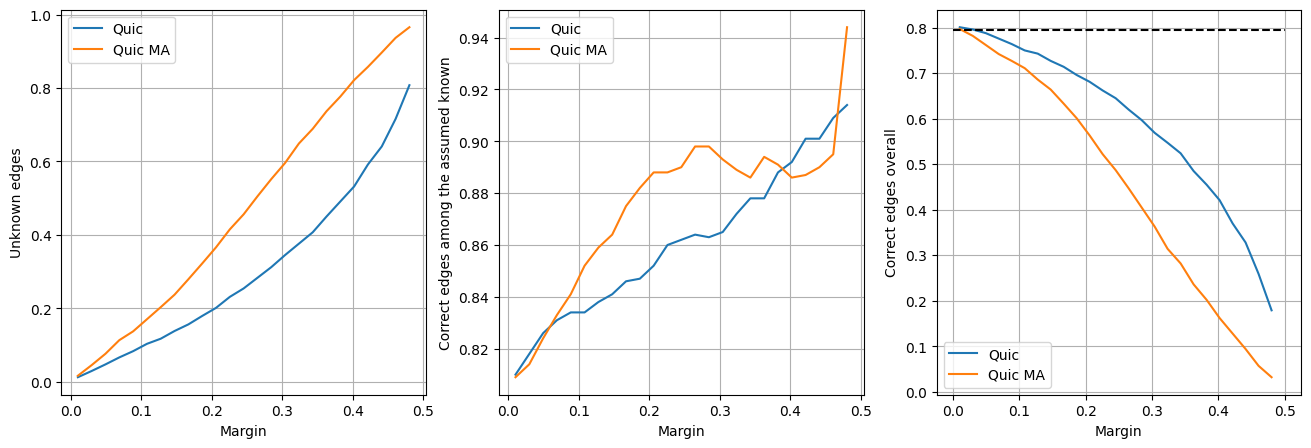

In [21]:
# Draw 3 plots, one for each metric
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ylabels = {
    "prop_unknown": "Unknown edges",
    "prop_known_correct": "Correct edges among the assumed known",
    "prop_correct": "Correct edges overall"

}
for i, metric in enumerate(["prop_unknown", "prop_known_correct", "prop_correct"]):
    ax[i].plot(margins[::2], metrics["quic"][metric][::2], label="Quic")
    ax[i].plot(margins[::2], metrics["quic_ma"][metric][::2], label="Quic MA")
    ax[i].set_xlabel("Margin")
    ax[i].set_ylabel(ylabels[metric])
    ax[i].legend()
    ax[i].grid()
ax[-1].plot([0, 0.5], [np.mean(metrics["graphical_lasso"]["prop_correct"])] * 2, "k--", label="Glasso")
plt.show()